# Projeto: Machine Learning I

<font size=4.5><center><b>Classificação binária com um conjunto de dados de previsão de AVC</b></center></font>

<p style='text-align: justify;'><font size=3>Segundo o Ministério da Saúde, o Acidente Vascular Cerebral é uma doença em que os vasos que levam sangue ao cérebro entopem ou se rompem, provocando uma paralisia na área que ficou sem circulação sanguínea. O AVC acomete mais os homens e é uma das principais causas de morte, incapacitação e internações em todo o mundo.</font></p>

<p style='text-align: justify;'><font size=3>A Organização Mundial da Saúde (OMS), afirma que o AVC é a 2ª principal causa de morte no mundo, responsável por aproximadamente 11% do total de óbitos. Com base nisso, nosso objetivo será aplicar técnicas de aprendizagem de máquina para prever se um paciente tem probabilidade de sofrer ou não um acidente vascular cerebral com base nos parâmetros do conjunto de dados com a intenção auxiliar na adoção de medidas de prevenção da doença.</font></p>


<font size=2><b>Fontes</b>: 
https://www.em.com.br/app/noticia/bem-viver/2022/04/18/interna_bem_viver,1360730/avc-e-a-segunda-causa-de-mortes-no-mundo-e-avanca-nos-paises-de-baixa-renda.shtml | https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/a/avc</font>


<font size=2><b>Fonte dos dados</b>: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv.</font>

<font size=2>Para baixar a base concatenada, acesso o drive: https://drive.google.com/drive/folders/1ccl2ocMkPtjqaC1-ktYa1kKzop_jXI1Y?usp=sharing</font>


![Descrição da Imagem](img/AVC-300x164.jpg)

<font size=4.5><center><b>Dicionário dos dados</b></center></font>

|Campos|Descrição|
|---|---|
|id|identificador único|
|gender|masculino, feminino ou outro|
|age|idade do paciente|
|hypertension|0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão|
|heart_disease|0 se o paciente não tiver nenhuma doença cardíaca, 1 se o paciente tiver uma doença cardíaca|
|ever_married|não ou sim|
|work_type|filhos, trabalho governamental, nunca trabalhei, privado, autônomo|
|Residence_type|rural ou urbano|
|avg_glucose_level|nível médio de glicose no sangue|
|bmi|índice de massa corporal|
|smoking_status|fumou anteriormente, nunca fumou, fuma ou desconhecido*|
|stroke| 1 se o paciente teve acidente vascular cerebral ou 0 se não|

*Nota: "Unknown" em smoking_status significa que a informação não está disponível para este paciente

### Imports necessários

In [5]:
"""
    Bibliotecas básicas de DS
"""
import warnings
import numpy as np
import pandas as pd

"""
    Bibliotecas de visualização de dados
"""
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

"""
 Bibliotecas para análise do dataset
"""
import sidetable

"""
 Biblioteca de ML
"""
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Conjunto de dados

In [6]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head(1)

Linhas: 5110 | Colunas: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


### Informação dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### Valores nulos

In [8]:
df.stb.missing()

,missing,total,percent
bmi,201,5110,3.933464
id,0,5110,0.000000
gender,0,5110,0.000000
age,0,5110,0.000000
hypertension,0,5110,0.000000
heart_disease,0,5110,0.000000
ever_married,0,5110,0.000000
work_type,0,5110,0.000000
Residence_type,0,5110,0.000000
avg_glucose_level,0,5110,0.000000


#### Imputação valores nulos

> Pelo fato do índice de massa corporal do paciente ser importante para identificar a obesidade, que é um fator de risco significativo para acidente vascular cerebral, optaremos por preencher valores nulos usando a técnica de interpolação linear. Essa técnica permite preencher esses nulos com valores intermediários usando como base os valores circundantes. Neste método, os valores intermediários são estimados por uma reta que liga os pontos de dados vizinhos

In [9]:
df['bmi'].interpolate(method='linear', inplace=True, limit_direction='both')

#### Correção tipo de dados

In [10]:
df['age'] = df['age'].astype(int)

mapSimOuNao = {0: 'No', 1: 'Yes'}
df['hypertension'] = df['hypertension'].map(mapSimOuNao)
df['heart_disease'] = df['heart_disease'].map(mapSimOuNao)
df['stroke'] = df['stroke'].map(mapSimOuNao)

### Seleção de features

> Removidas as features não relevantes para as análises

In [11]:
df.drop(['id'], axis=1, inplace=True)

### Base final

In [12]:
df.sample(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
796,Female,29,No,No,No,Private,Urban,60.26,20.4,never smoked,No
5105,Female,80,Yes,No,Yes,Private,Urban,83.75,29.3,never smoked,No
2617,Male,53,No,No,Yes,Private,Urban,86.25,29.3,never smoked,No
4257,Female,24,No,No,No,Self-employed,Urban,79.42,21.4,never smoked,No
4676,Female,28,No,No,No,Private,Urban,73.20,26.5,smokes,No


### Perfil médio de todos os pacientes

In [13]:
df.describe().round(2)

,age,avg_glucose_level,bmi
count,5110.00,5110.00,5110.00
mean,43.22,106.15,28.93
std,22.63,45.28,7.78
min,0.00,55.12,10.30
25%,25.00,77.24,23.60
50%,45.00,91.88,28.10
75%,61.00,114.09,33.10
max,82.00,271.74,97.60


<p style='text-align: justify;'><font size=3.>A idade dos pacientes na base de dados varia consideravelmente, com valores entre 0 e 82 anos. A média de idade é de aproximadamente 43 anos, com a maioria dos pacientes tendo idades entre 25 e 61 anos. A idade mínima na base de dados é 0, embora isso possa ser problemático, será mantido considerando que a variável work_type deixa claro que são crianças.</font></p>

<p style='text-align: justify;'><font size=3.>O nível médio de glicose no sangue varia significativamente, com valores entre 55,12 e 271,74. Essa variação indica que alguns pacientes têm níveis muito baixos e outros têm níveis muito altos de glicose. A média está em torno de 106,15, indicando que a maioria dos pacientes tem níveis de glicose na faixa intermediária.</font></p>

<p style='text-align: justify;'><font size=3.>O IMC também varia consideravelmente,entre 10,30 a 97,60. A média é de cerca de 28,93, o que está na faixa de sobrepeso, com o desvio padrão de aproximadamente 7,78. Isso significa que os valores estão bastante espalhados em relação à média, o que pode indicar pacientes com grande variação de peso corporal, sendo alguns deles consideravelmente acima da média e outros significativamente abaixo.</font></p>

In [14]:
df.describe(include='O')

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2994,4612,4834,3353,2925,2596,1892,4861


<p style='text-align: justify;'><font size=3.>A base de dados é composta, majoritariamente, por pacientes do sexo feminino. Vemos também que a maioria não tem hipertensão, não possui doença cardíaca e não tiveram um AVC. Além disso, a maior parte dos pacientes trabalha no setor privado, reside em áreas urbana, é casada e nunca fumou.</font></p>

### Outliers

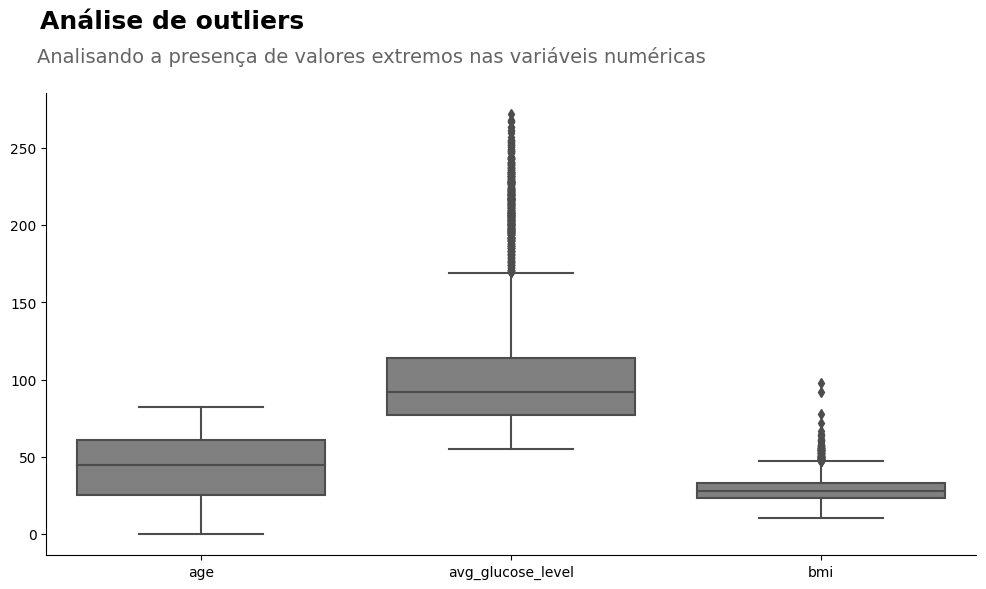

In [15]:
suptitle = 'Análise de outliers'
title = 'Analisando a presença de valores extremos nas variáveis numéricas'

ax = sns.boxplot(data=df, color='#808080')
ax.figure.set_size_inches(12, 6)
ax.spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Analisando os dados em busca de outliers podemos ver que alguns pacientes apresentam valores de glicose em níveis elevados e a maioria dos pacientes tem índices de massa corporal acima do normal, indicando um potencial problema de sobrepeso. Esses valores extremos são informações importantes, uma vez que diabetes, sobrepeso e obesidade são alguns dos fatores que aumentam a probabilidade de ocorrência de um AVC.</font></p>

### Stroke vs. Não stroke

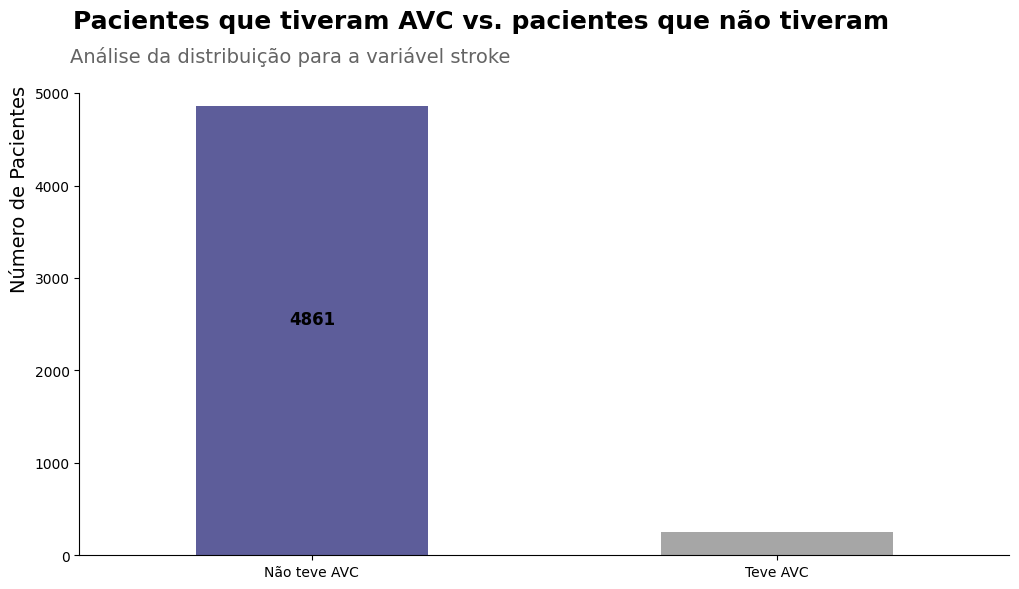

In [16]:
suptitle = 'Pacientes que tiveram AVC vs. pacientes que não tiveram'
title = 'Análise da distribuição para a variável stroke'
colors=['#191970', '#808080']

strokeCounts = df['stroke'].value_counts()
strokeCounts.plot.bar(width=0.5, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel(None)
plt.ylabel('Número de Pacientes', fontsize=14, horizontalalignment='left', y=0.57)
plt.xticks([0, 1], ['Não teve AVC', 'Teve AVC'])
plt.text(0, 2500, '4861', fontsize=12, weight='bold', horizontalalignment='center')
plt.ylim(0, 5000)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>A distribuição de pacientes que tiveram AVC em comparação com aqueles que não tiveram mostra um desequilíbrio significativo das classes. Isso significa que a maioria dos pacientes na base de dados não teve um derrame, como já tinhamos visto antes. Isso pode ser um desafio na hora de desenvolver modelos de aprendizado de máquina, uma vez que modelos treinados em dados desequilibrados podem ser tendenciosos em direção à classe majoritária.</font></p>

## Perfil dos clientes que tiveram AVC

> Como nosso interesse é predizer um AVC, vamos avaliar o perfil dos pacientes que tiveram.

In [17]:
avc = df.query('stroke=="Yes"')
print(f'Total de pacientes tiveram AVC: {len(avc)}')

Total de pacientes tiveram AVC: 249


### Idade

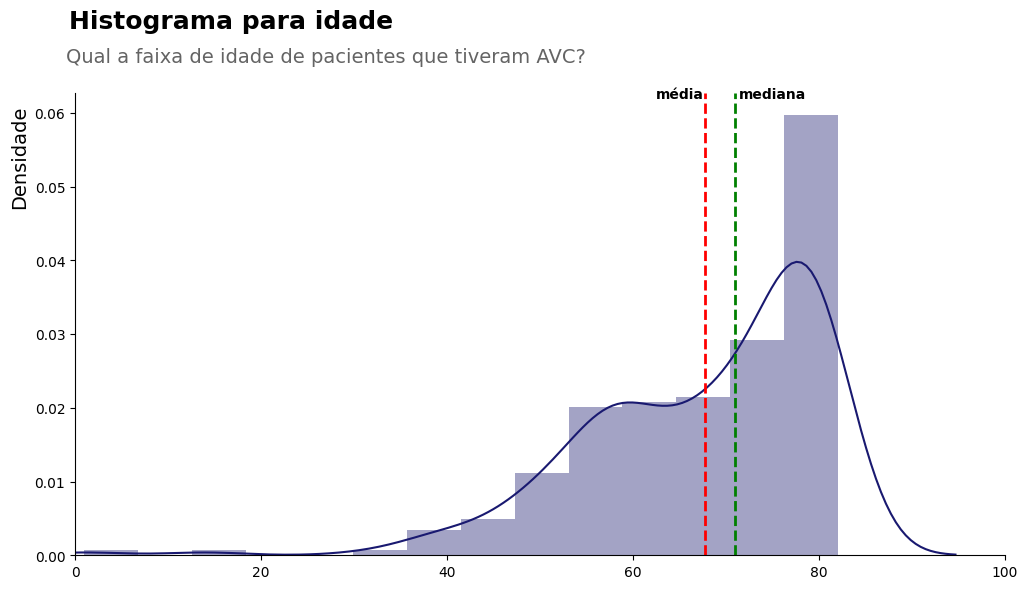

In [18]:
suptitle = 'Histograma para idade'
title = 'Qual a faixa de idade de pacientes que tiveram AVC?'

ax = sns.distplot(avc['age'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.75)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)

plt.axvline(x=67.727, color='r', linestyle='dashed', linewidth=2, label='Média')
plt.text(65, 0.062, 'média', fontsize=10, weight='bold', horizontalalignment='center')

plt.axvline(x=71.000, color='g', linestyle='dashed', linewidth=2, label='Mediana')
plt.text(75, 0.062, 'mediana', fontsize=10, weight='bold', horizontalalignment='center')

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlim(0, 100)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Em média, os pacientes que sofreram um AVC têm cerca de 68 anos de idade, com o desvio padrão de aproximadamente 13 anos, que indica que alguns pacientes podem ter idades significativamente mais jovens ou mais velhas que a média. Podemos perceber que há uma concentração significativa de casos em pacientes com idades mais avançadas, mas também alguns casos em idades mais jovens. A mediana é de 71 anos, o que significa que metade dos pacientes tem 71 anos ou menos e a outra metade está acima de 71.</font></p>

<p style='text-align: justify;'><font size=3.>Esse resultado faz sentido uma vez que, segundo o Ministério da Saúde, pessoas com mais de 55 anos possuem maior propensão a desenvolver o AVC.</font></p>


<font size=2><b>Fontes</b>: https://bvsms.saude.gov.br/avc-acidente-vascular-cerebral/</font>

### Sexo biológico

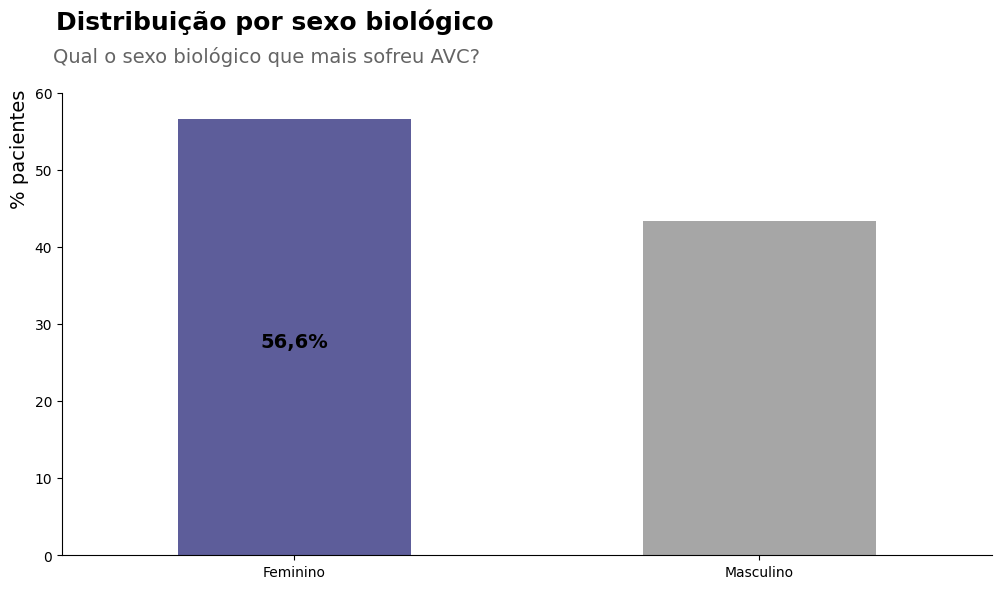

In [19]:
suptitle = 'Distribuição por sexo biológico'
title = 'Qual o sexo biológico que mais sofreu AVC?'
colors=['#191970', '#808080']

dist_freq = (avc['gender'].value_counts(normalize=True)*100).round(2).reset_index()
dist_freq['gender'].plot.bar(width=0.5, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% pacientes', fontsize=14, horizontalalignment='left', y=0.75)
plt.ylim(0, 60)
plt.grid(False)
plt.text(0, 27, '56,6%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Feminino', 'Masculino'])
plt.show()

<p style='text-align: justify;'><font size=3.>É possível identificar que 56,6% dos pacientes que sofreram AVC é do sexo feminino. Esse é um resultado interessante, uma vez que, ainda de acordo com Ministério da Saúde, pessoas do sexo masculino exibem maior tendência ao desenvolvimento de AVC. Portanto, é importante observar que essa análise refere-se apenas a essa amostra de dados, não refletindo, necessariamente, a realidade.</font></p>

<font size=2><b>Fontes</b>: https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/a/avc</font>

### Estado civil

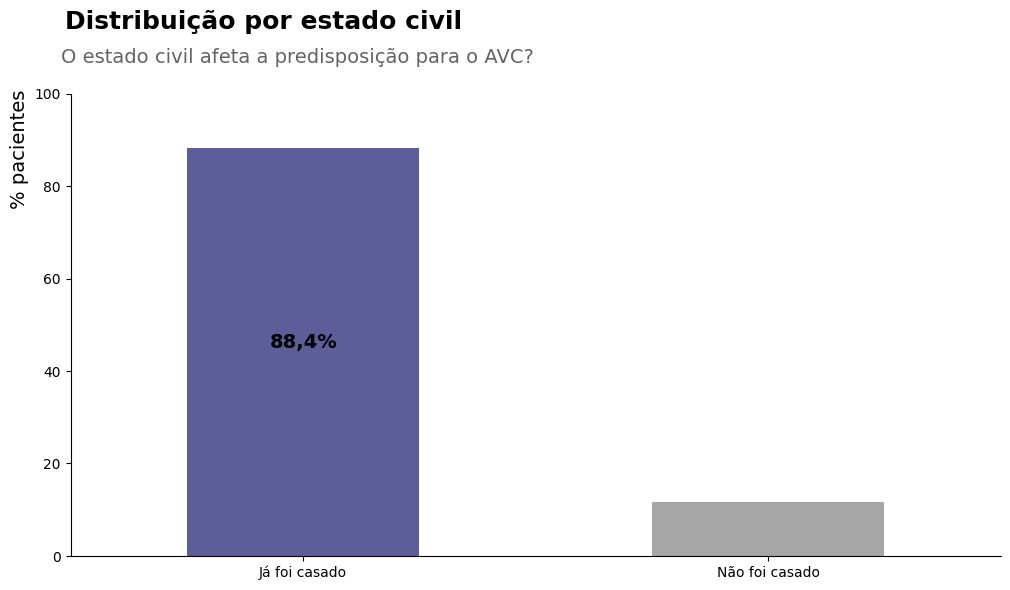

In [20]:
suptitle = 'Distribuição por estado civil'
title = 'O estado civil afeta a predisposição para o AVC?'
colors=['#191970', '#808080']

dist_freq = (avc['ever_married'].value_counts(normalize=True)*100).round(2).reset_index()
dist_freq['ever_married'].plot.bar(width=0.5, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% pacientes', fontsize=14, horizontalalignment='left', y=0.75)
plt.ylim(0, 100)
plt.grid(False)
plt.text(0, 45, '88,4%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Já foi casado', 'Não foi casado'])
plt.show()

<p style='text-align: justify;'><font size=3.>A porcentagem de pacientes com AVC que já foram casados é de 88,35%. Esse resultado é significativamente maior do que a dos pacientes não casados, o que pode sugerir que o estado civil pode estar associado a uma maior ou menor probabilidade de AVC. Embora não seja reconhecido como um fator de risco direto, o estado civil pode estar associado à um estilo de vida que pode levar a fatores de riscos relacionados à doenca, como por exemplo, sedentarismo ou hábitos alimentares. Porém, vale ressaltar que são apenas suposições e um estudo mais detalhado deve ser realizado.</font></p>

### Hipertensão

### Doenças do coração

### Tipo de trabalho

### Tipo de residência

### Nível de glicose

### Índice de massa corporal

### Status de fumante

### Correlação entre variáveis

## Modelagem com MLflow